# **Semantic Segmentation Competition (30%)**

For this competition, we will use a small autonomous driving dataset. The dataset contains 150 training images and 50 testing images.

We provide baseline code that includes the following features:

*    Loading the dataset using PyTorch.
*    Defining a simple convolutional neural network for semantic segmentation.
*    How to use existing loss function for the model learning.
*    Train the network on the training data.
*    Test the trained network on the testing data.

The following changes could be considered:
-------
1. Data augmentation
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, and Drop-out.
3. Architectural changes: Batch Normalization, Residual layers, etc.
4. Use of a new loss function.

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark
###Acc_mark 10:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

###Efficiency mark 10:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 30:
Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]



#1. Download data and set configs

In [1]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: ABC, XYZ
### Student ID: a123456, a654321
### Comptetion Name: Semantic Segmentation Competition
### Final Results:
### ACC:         GFLOPs:
##################################################################################################################################

In [2]:
#1.1 Download the dataset.
# dowanload and unzip the dataset

In [3]:
#1.2 Set configs
#Use Colab or install PyTorch 1.9 on your local machine to run the code.
import os
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tf
from PIL import Image
import shutil
from torch.utils.data import Dataset, DataLoader

#--------Data path----------
# Use your data path to replace the following path if you use Google drive.
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path. Ensure that the file path correspond to the path you have here. It is expected that you unzip the data folders before running the notebook.
# dataFolder = '/content/drive/MyDrive/Datasets/seg_data'
# dataFolder = './seg_data' # local path if you run the code on your local machine.
dataFolder = '/kaggle/input/seg-data/seg_data'  #kaggle input path

# To access Google Colab GPU; Go To: Edit >>> Notebook Settings >>> Hardware Accelarator: Select GPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device: {}'.format(device))

#---------Config----------
learning_rate = 3e-4 #Tips: design a strategy to adjust the learning rate
# learning_rate = 1e-3 # can be adjusted
width = 864 # image width and height
height = 256 #
# batchSize = 4 #can be adjusted
batchSize = 2 # can be adjusted
# batchSize = 8 
epochs = 180 #can be adjusted

# if not os.path.exists(dataFolder):
#    print('Data Path Error! Pls check your data path')
if not torch.cuda.is_available():
  print('WARNING! The device is CPU NOT GPU! Pls avoid using CPU for training')

device: cuda


# 2. Define a dataloader to load data

In [4]:
#The class to load images and labels
class ExpDataSet(Dataset):
    def __init__(self, dataFolder):
        self.image_path = os.listdir(os.path.join(dataFolder, "training/image"))
        self.label_path = os.listdir(os.path.join(dataFolder, "training/image"))#Image name only
        print('load info for {} images'.format(len(self.image_path)))
        assert len(self.image_path) == 150
        for idx in range(0, len(self.image_path)):
            assert self.image_path[idx] == self.label_path[idx] #same
            self.image_path[idx] = os.path.join(dataFolder, "training/image", self.image_path[idx])
            self.label_path[idx] = os.path.join(dataFolder, "training/label", self.label_path[idx])
        # --------------------Transformation functions----------------
        #-------------Tips: data augmentation can be used (for example flip, resize)-------------
        self.transformImg = tf.Compose([
            tf.ToPILImage(),
            tf.RandomResizedCrop((height, width), scale=(0.8, 1.0)),  # Crop
            tf.RandomRotation(degrees=10),                            # Rotation
            tf.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Jitter
            tf.GaussianBlur(kernel_size=3),                           # Blur
            tf.ToTensor(),
            tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
        self.transformLabel = tf.Compose([tf.ToPILImage(),
                                           tf.Resize((height, width), 
                                                     tf.InterpolationMode.NEAREST)])
    def __getitem__(self, idx):
        img = cv2.imread(self.image_path[idx])[:, :, 0:3]
        label = cv2.imread(self.label_path[idx], 0)
        img = self.transformImg(img)  #3*H*W
        label = self.transformLabel(label)
        label = torch.tensor(np.array(label))  #H*W
        return img, label
    def __len__(self):
        return len(self.image_path)

#Get the predefined dataloader
exp_data = ExpDataSet(dataFolder)
train_loader = DataLoader(exp_data, batch_size=batchSize, shuffle=True, num_workers=2)

load info for 150 images


#3. Define a convolutional neural network

In [5]:
#Define the semantic segmentation network. Tips: a new network can be used
class SegNetwork(nn.Module):
    def __init__(self, n_class=19):
        super(SegNetwork, self).__init__()
        #stage 1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  #1/2
        #stage 2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  #1/4
        #stage 3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  #1/8
        #stage 4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  #1/16
        #stage 5
        self.conv5_1 = nn.Conv2d(512, 2048, 3)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.drop5_1 = nn.Dropout2d()
        self.conv5_2 = nn.Conv2d(2048, 2048, 1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.drop5_2 = nn.Dropout2d()
        self.conv5_3 = nn.Conv2d(2048, n_class, 1)
        #upsample
        self.upsample_cov1 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, output_padding=1, bias=False) #upsample
        self.upsample_cov2 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False) #upsample  -> 1/4
        self.upsample_cov3 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, padding=1, bias=False)  # upsample  -> 1/2

    def forward(self, x):
        inp_shape = x.shape[2:]
        x = self.relu1_1(self.conv1_1(x))
        x = self.relu1_2(self.conv1_2(x))
        x = self.pool1(x)

        x = self.relu2_1(self.conv2_1(x))
        x = self.pool2(x)

        x = self.relu3_1(self.conv3_1(x))
        x = self.pool3(x)

        x = self.relu4_1(self.conv4_1(x))
        x = self.pool4(x)

        x = self.relu5_1(self.conv5_1(x))
        x = self.drop5_1(x)
        x = self.relu5_2(self.conv5_2(x))
        x = self.drop5_2(x)
        x = self.conv5_3(x)

        x = self.upsample_cov1(x)
        x = self.upsample_cov2(x)
        x = self.upsample_cov3(x)
        x = F.interpolate(x, size=inp_shape, mode="bilinear", align_corners=True)#resize (1/2 -> original size)
        return x

#Get the predefined network
segNet = SegNetwork(n_class=19).to(device)

#4. Define a loss function and optimizer

In [6]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
# optimizer = torch.optim.Adam(params=segNet.parameters(), lr=learning_rate)
optimizer = torch.optim.AdamW(params=segNet.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

#5. The function used to compare the precision

In [7]:
#------------------Modification of this function is ***NOT*** allowed---------------
def cal_acc(pred_folder, gt_folder, classes=19):
    class AverageMeter(object):
        def __init__(self):
            self.reset()
        def reset(self):
            self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
        def update(self, val, n=1):
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count
    def intersectionAndUnion(output, target, K, ignore_index=255):
        assert (output.ndim in [1, 2, 3])
        assert output.shape == target.shape
        output = output.reshape(output.size).copy()
        target = target.reshape(target.size)
        output[np.where(target == ignore_index)[0]] = ignore_index
        intersection = output[np.where(output == target)[0]]
        area_intersection, _ = np.histogram(intersection, bins=np.arange(K + 1))
        area_output, _ = np.histogram(output, bins=np.arange(K + 1))
        area_target, _ = np.histogram(target, bins=np.arange(K + 1))
        area_union = area_output + area_target - area_intersection
        return area_intersection, area_union, area_target
    data_list = os.listdir(gt_folder)
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    for i, image_name in enumerate(data_list):
        pred = cv2.imread(os.path.join(pred_folder, image_name), cv2.IMREAD_GRAYSCALE)
        target = cv2.imread(os.path.join(gt_folder, image_name), cv2.IMREAD_GRAYSCALE)
        intersection, union, target = intersectionAndUnion(pred, target, classes)
        intersection_meter.update(intersection)
        union_meter.update(union)
        target_meter.update(target)
    iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
    mIoU = np.mean(iou_class)
    print('Eval result: mIoU {:.4f}.'.format(mIoU))
    return mIoU

#6. Define functions to get and save predictions

In [8]:
def make_folder(dir_name):#make a folder
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

def move_folders(grey_temp, color_temp, grey_rs, color_rs):#move folders
    if os.path.exists(grey_temp):
        make_folder(grey_rs)
        for file in os.listdir(grey_temp):
            shutil.move(os.path.join(grey_temp, file), os.path.join(grey_rs, file))
        if os.path.exists(grey_temp):
            shutil.rmtree(grey_temp)
    if os.path.exists(color_temp):
        make_folder(color_rs)
        for file in os.listdir(color_temp):
            shutil.move(os.path.join(color_temp, file), os.path.join(color_rs, file))
        if os.path.exists(color_temp):
            shutil.rmtree(color_temp)

def colorize(gray, palette):#visualize predictions results
    color = Image.fromarray(gray.astype(np.uint8)).convert('P')
    color.putpalette(palette)
    return color

#-------Perform evaluation for a network and save prediction results--------
def get_predictions(segNet, dataFolder, device):#params: a network, data path, device
    gray_folder, color_folder = './temp_grey', './temp_color'
    listImages, gt_folder = os.listdir(os.path.join(dataFolder, "testing/image")), os.path.join(dataFolder, "testing/label")
    colors_path  = os.path.join(dataFolder, "colors.txt") #colors for visualizing greyscale images
    print('Begin testing')
    make_folder(gray_folder)
    make_folder(color_folder)
    colors = np.loadtxt(colors_path).astype('uint8')
    #Tips: muti-scale testing can be used
    transformTest = tf.Compose([tf.ToPILImage(), tf.ToTensor(),
                                tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    for idx in range(0, len(listImages)):
        img = cv2.imread(os.path.join(dataFolder, "testing/image", listImages[idx]))[:, :, 0:3]
        img = transformTest(img).unsqueeze(0)  #1*3*H*W
        prediction = segNet(img.to(device))
        prediction = prediction[0].cpu().detach().numpy()
        prediction = np.argmax(prediction, axis=0)
        gray = np.uint8(prediction)
        color = colorize(gray, colors)
        gray_path = os.path.join(gray_folder, listImages[idx])
        color_path = os.path.join(color_folder, listImages[idx])
        cv2.imwrite(gray_path, gray)
        color.save(color_path)
    return gray_folder, color_folder #return folders (paths) which contain grey and color predictions.

#7. Train the network

In [9]:
#The training will take ~1 h.
mIoU = 0.0
IoU_list = []
train_loss = []
evl_each = True #Perform evaluation after each epoch. You can define the false case to save training time
for epoch in range(epochs):
    for iter, (imgs, labels) in enumerate(train_loader):
        pred = segNet(imgs.to(device))
        segNet.zero_grad()
        loss = criterion(pred, labels.long().to(device)) #calculate the loss
        train_loss.append(loss.detach().cpu().numpy().item())
        loss.backward()
        optimizer.step()
        print('epoch {} iter {} loss={}'.format(epoch, iter, loss.data.cpu().numpy()))

#-----Evaluation------
    if evl_each and epoch>100:
        segNet.eval()  # The eval() must be called before evaluation
        gray_folder, color_folder = get_predictions(segNet, dataFolder, device) #Temp prediction results
        segNet.train()
        temp_mIoU = cal_acc(gray_folder, os.path.join(dataFolder, 'testing/label'))
        IoU_list.append(temp_mIoU)
        if temp_mIoU > mIoU:
            mIoU = temp_mIoU
            torch.save(segNet.state_dict(), './model.pth')
            move_folders(gray_folder, color_folder, # Temp results -> final results
                         gray_folder.replace('temp_', ''),
                         color_folder.replace('temp_', ''))
        scheduler.step()
print('The final mIoU is : {:.4f}.'.format(mIoU)) #The final mIoU is ~0.28
#Remember to download the results before closing the tab!

epoch 0 iter 0 loss=2.9444215297698975
epoch 0 iter 1 loss=2.944270133972168
epoch 0 iter 2 loss=2.9439315795898438
epoch 0 iter 3 loss=2.9429614543914795
epoch 0 iter 4 loss=2.939359426498413
epoch 0 iter 5 loss=2.9257419109344482
epoch 0 iter 6 loss=2.906870126724243
epoch 0 iter 7 loss=2.9357786178588867
epoch 0 iter 8 loss=2.690106153488159
epoch 0 iter 9 loss=2.7742364406585693
epoch 0 iter 10 loss=2.687223434448242
epoch 0 iter 11 loss=2.497195243835449
epoch 0 iter 12 loss=2.7398056983947754
epoch 0 iter 13 loss=2.2383482456207275
epoch 0 iter 14 loss=2.360994338989258
epoch 0 iter 15 loss=3.0196168422698975
epoch 0 iter 16 loss=2.333083152770996
epoch 0 iter 17 loss=2.118856191635132
epoch 0 iter 18 loss=2.1449220180511475
epoch 0 iter 19 loss=2.4490678310394287
epoch 0 iter 20 loss=2.428736448287964
epoch 0 iter 21 loss=2.324101686477661
epoch 0 iter 22 loss=2.1984877586364746
epoch 0 iter 23 loss=1.9126722812652588
epoch 0 iter 24 loss=2.133629322052002
epoch 0 iter 25 loss=2

In [10]:
from matplotlib import pyplot as plt

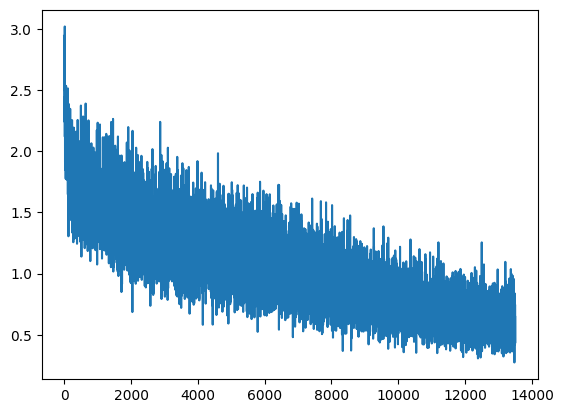

In [11]:
plt.plot(train_loss,label="train_loss")

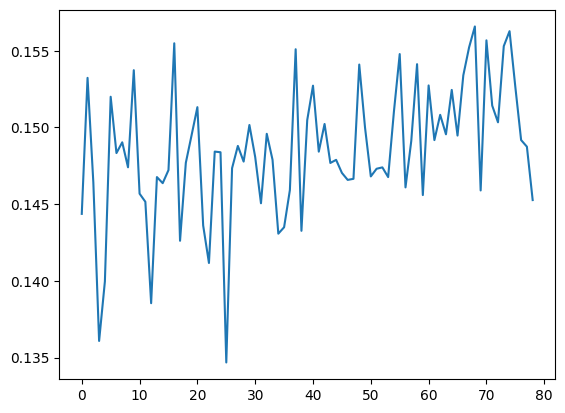

In [12]:
plt.plot(IoU_list,label="IoU")


A prediction example by using the baseline:

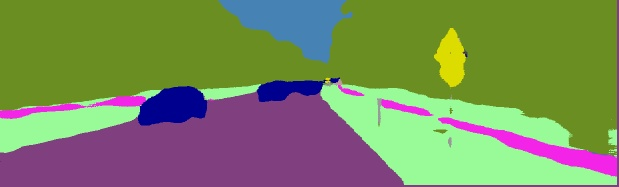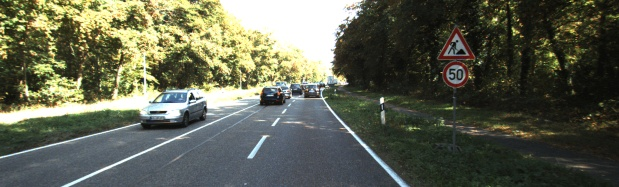

#8. FLOPs
In deep learning, FLOPs (Floating Point Operations) quantify the total number of arithmetic operations—such as additions, multiplications, and divisions—that a model performs during a single forward pass (i.e., when making a prediction). This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs (Giga Floating Point Operations), where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

In [13]:
# we use fvcore to calculate the FLOPs
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=8a563c8278dad9a91aea9c1b3cd895d6fac78aafab76686b53a9c1c852cf2bf0
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=e62da1660ae453d8334217b7f1d3981c05776506e5300b6473ffcb90493c090a
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [14]:
from fvcore.nn import FlopCountAnalysis
input = torch.randn(1, 3, 375, 1242) # Modifying the size (3, 375, 1242) is ***NOT*** allowed.

#Get the network and its FLOPs
model = SegNetwork(n_class=19)
flops = FlopCountAnalysis(model, input)
print(f"FLOPs: {flops.total()/1e9:.2f} GFLOPs")

FLOPs: 66.97 GFLOPs
